In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# from arch.bootstrap import StationaryBootstrap
# from arch.bootstrap import IndependentSamplesBootstrap
# from arch.bootstrap import bootstrapped_difference
# from bootstrapped import bootstrap as bs
# from bootstrapped import compare_functions as cf
import hdbscan
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import ArrowStyle
import math
import numpy as np
import networkx as nx
import os
import pandas as pd
import pickle
import random
from scipy.optimize import nnls
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import mannwhitneyu, normaltest
from scipy.spatial.distance import jensenshannon
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import affinity_propagation
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from itertools import product
import string

/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/atheistpoet/anaconda3/envs/s

In [4]:
from utils import create_abundance_header_new, compute_cons_abun_prod, hierarchical_cluster_metabs, \
    get_metabs_clusters, avg_consumption_df, fit_ss_Ri, match_lhs_rhs_fit, \
    blindly_pred_abun_growth, blindly_pred_abun_growth_no_f, blindly_pred_abun_growth_logRatio, \
    fit_dynamic_Ri, fit_dynamic_Ri_no_f, fit_dynamic_Ri_logRatio, compute_growth_ratio_iterate_blind_seq, \
    blindly_pred_abun_growth_seq, blindly_pred_abun_loggrowth, remove_passages, fit_dynamic_Ri_with_sim_inoc, \
    fit_dynamic_Ri_with_sim_inoc_bal, compute_Ri_dynamic_goodness_of_fit, \
    plot_panel_pred_vs_obs_abundance_blind, compute_growth_ratio_iterate_blind, \
    blindly_pred_abun_growth_without_inoc, load_data, metabs_to_remove_knockdown_species, \
    get_RMSE_Balone_func, get_RMSE_Balone_func_logRatio, get_B_alone_func, iterate_growth_ratio, geometric_avg, \
    get_RMSE_against_uniform_sd, random_competition_index, random_crossfeeding_index, get_competition, \
    get_crossfeeding, random_competition_subset

# Get Data

In [5]:
df_speciesMetab, df_speciesAbun, \
    df_speciesAbun_super_agar, \
    df_speciesAbun_mucin, \
    df_speciesAbun_inoc, \
    df_speciesAbun_ratio, \
    df_speciesAbun_super_agar_ratio, \
    df_speciesAbun_mucin_ratio, \
    df_speciesAbun_prev, \
    df_speciesAbun_super_agar_prev, \
    df_speciesAbun_mucin_prev, \
    df_speciesAbun_next, \
    df_speciesAbun_super_agar_next, \
    df_speciesAbun_mucin_next, metab_names, \
    species_names_tmp, df_speciesMetab_prod = \
        load_data(thresh_zero=1e-8)

In [6]:
species_names = []
filepath_ = os.path.abspath(os.path.join('..', 'data', 'jin_pollard', \
                                    'convert_usedNames_to_jinPollardNames.csv'))
df_names_convert = pd.read_csv(filepath_, index_col=None)

for sp_ in range(len(species_names_tmp)):
    id_ = np.where(df_names_convert.iloc[:, 0].values == species_names_tmp[sp_])[0]
    species_names.append(df_names_convert.iloc[id_, 1].values[0])
species_names = np.array(species_names)

In [7]:
species_names

array(['Acidaminococcus-fermentans-DSM-20731',
       'Acidaminococcus-intestini-D21', 'Anaerostipes-caccae-DSM-14662',
       'Anaerotruncus-colihominis-DSM-17241',
       'Bacteroides-caccae-ATCC-43185',
       'Bacteroides-cellulosilyticus-DSM-14838',
       'Bacteroides-coprophilus-DSM-18228', 'Bacteroides-dorei-5-1-36-D4',
       'Bacteroides-dorei-DSM-17855', 'Bacteroides-eggerthii-DSM-20697',
       'Bacteroides-finegoldii-DSM-17565', 'Bacteroides-fragilis-3-1-12',
       'Bacteroides-intestinalis-DSM-17393',
       'Bacteroides-ovatus-ATCC-8483', 'Bacteroides-plebeius-DSM-17135',
       'Bacteroides-thetaiotaomicron-1-1-6',
       'Bacteroides-fragilis-2-1-16', 'Bacteroides-sp-2-1-22',
       'Bacteroides-sp-3-1-19', 'Bacteroides-sp-9-1-42FAA',
       'Bacteroides-sp-D2', 'Bacteroides-stercoris-ATCC-43183',
       'Bacteroides-thetaiotaomicron-VPI-5482',
       'Bacteroides-uniformis-ATCC-8492',
       'Bacteroides-vulgatus-ATCC-8482',
       'Bifidobacterium-adolescentis-L2-32

# Set Params

In [8]:
# species_names = species_names[id_species_keep]
id_species_keep = np.arange(len(species_names))

In [9]:
num_species = len(species_names)
num_metabs = len(metab_names)
num_passages = 6
num_bioRep = 3

In [10]:
date_meeting = "20231207"

In [11]:
date_ = "20231207"
distance_metric = 'euclidean'
# distance_metric = 'correlation'
metab_cluster_mean_func = 'geometric'
metab_cluster_mean_func = "linear"
clustering_method = "hdbscan"
clustering_method = "hierarch_clust"
random_seed = 635
# random_seed = 9876
# random_seed = 7360
# microcosm_type = "supernatantAgar"
# microcosm_type = "mucin"
microcosm_type = "noMicrocosm"

In [12]:
if microcosm_type == "noMicrocosm":
    df_speciesAbun_mdl = df_speciesAbun.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_ratio.copy()
elif microcosm_type == "supernatantAgar":
    df_speciesAbun_mdl = df_speciesAbun_super_agar.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_super_agar_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_super_agar_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_super_agar_ratio.copy()
elif microcosm_type == "mucin":
    df_speciesAbun_mdl = df_speciesAbun_mucin.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_mucin_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_mucin_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_mucin_ratio.copy()

In [13]:
D_ = 15000
df_speciesAbun_ratio_mdl * D_

,p2_r0,p3_r0,p4_r0,p5_r0,p6_r0,p2_r1,p3_r1,p4_r1,p5_r1,p6_r1,p2_r2,p3_r2,p4_r2,p5_r2,p6_r2
0,58.133623,815.916366,43948.661059,223265.431534,34243.686957,60.355572,27842.468305,173852.691324,122357.203160,3888.612002,216.636800,5614.034129,6111.708845,19053.310735,31797.952066
1,14784.607245,21239.331187,13755.124490,13200.987966,17468.423575,13693.015396,20225.176548,17067.722624,12206.132429,16054.490938,19354.055096,21871.953910,15310.053230,15052.478609,13438.140108
2,38772.118085,7941.049206,5574.889189,24279.162818,4585.666877,4244.701407,49083.652235,8114.991600,20141.857996,4289.544117,2163.703346,52531.173992,6751.300892,119987.106096,2037.481251
3,1.962928,-15000.000000,-15000.000000,-15000.000000,-15000.000000,209.250088,2650.289242,664.528444,120421.479203,1868.437437,151.904734,188.317494,-15000.000000,-15000.000000,236340.259918
4,5.076733,1830.685025,17856.824171,8107.494481,18265.921783,8.551046,1733.031933,20140.182227,3104.926293,20446.999442,25.368346,21972.175876,268.914287,25914.366631,5965.006316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,198213.155135,3408.184541,9005.306669,16926.228146,19843.959436,86756.672322,5782.165550,13587.699643,18105.082142,3802.644561,37565.549048,4908.226359,12765.010821,36195.781539,13098.639428
59,4962.328974,493.046469,20713.039484,68958.197894,8686.735436,2103.796143,23886.250250,4857.828501,55083.723930,11342.761563,2306.563026,16754.785731,11005.582863,4918.293138,132785.386241
60,24661.194363,7299.523155,23504.262062,8346.632384,11758.686136,22543.963396,10404.214900,6308.087281,5666.202268,17141.756076,17017.712529,20493.747286,17458.989824,6860.174655,9023.335222
61,386.599359,129940.391794,1731.563195,-15000.000000,-15000.000000,242.825217,-15000.000000,218985.850042,1027.463646,-15000.000000,181.207477,-15000.000000,-15000.000000,-15000.000000,-15000.000000


In [14]:
mat_ = np.array(df_speciesAbun_ratio_mdl)
np.min(mat_[mat_ >= 0]) * D_

0.3160113808235055

In [15]:
id_ = np.where((mat_ >= 0) & (mat_ * D_ < 1))
mat_[id_]
id_

(array([49]), array([1]))

In [16]:
df_speciesAbun_ratio_mdl.iloc[49, 1] = -1

In [17]:
df_speciesAbun_ratio_mdl.iloc[49, 1] 

-1.0

In [18]:
df_speciesAbun_next_mdl.iloc[49, 1]

1e-08

In [19]:
df_speciesAbun_mdl.iloc[49, 2]

1e-08

# cluster metabolites

In [20]:
# pass_keep = remove_passages(pass_rm_list=[0, 1, 3, 4, 5])
# abun_avg_pass_3 = np.array(df_speciesAbun_mdl.iloc[:, pass_keep])
# abun_avg_pass_3 = np.mean(np.log10(abun_avg_pass_3), axis=1)
# id_sp_keep = np.where(abun_avg_pass_3 >= -5)[0]
# df_speciesAbun_mdl = df_speciesAbun_mdl.iloc[id_sp_keep, :].copy()
# df_speciesAbun_prev_mdl = df_speciesAbun_prev_mdl.iloc[id_sp_keep, :].copy()
# df_speciesAbun_next_mdl = df_speciesAbun_next_mdl.iloc[id_sp_keep, :].copy()
# df_speciesAbun_ratio_mdl = df_speciesAbun_ratio_mdl.iloc[id_sp_keep, :].copy()
# df_speciesMetab = df_speciesMetab.iloc[id_sp_keep, :].copy()
# df_speciesMetab_prod = df_speciesMetab_prod.iloc[id_sp_keep, :].copy()
# df_speciesAbun_inoc = df_speciesAbun_inoc.iloc[id_sp_keep, :].copy()
id_sp_keep = np.arange(df_speciesAbun_mdl.shape[0])

In [21]:
df_speciesAbun_mdl.shape

(63, 18)

In [22]:
nclusts = 10
df_metabs_clusters, df_speciesMetab_new, df_speciesMetab_prod_new = \
    get_metabs_clusters(df_speciesMetab.copy(), df_speciesMetab_prod.copy(), \
                        bin_thresh=0.3, species_num_thresh=5, \
                        n_clusters_hclust=nclusts, distance_metric="euclidean", \
                        method_cluster="ward", normalize_=False)
df_speciesMetab_cluster, df_speciesMetab_prod_cluster = \
    avg_consumption_df(df_speciesMetab_new, df_speciesMetab_prod_new, df_metabs_clusters, \
                       metab_cluster_mean_func="geometric")

In [23]:
df_metabs_clusters_unnorm = df_metabs_clusters.copy()

In [24]:
metab_cluster_names = []
for m_ in range(df_speciesMetab_cluster.shape[1]):
    metab_cluster_names.append(f'{m_ + 1}')

In [25]:
df_speciesMetab_cluster_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_cluster.columns = metab_cluster_names
# len(metab_cluster_names)

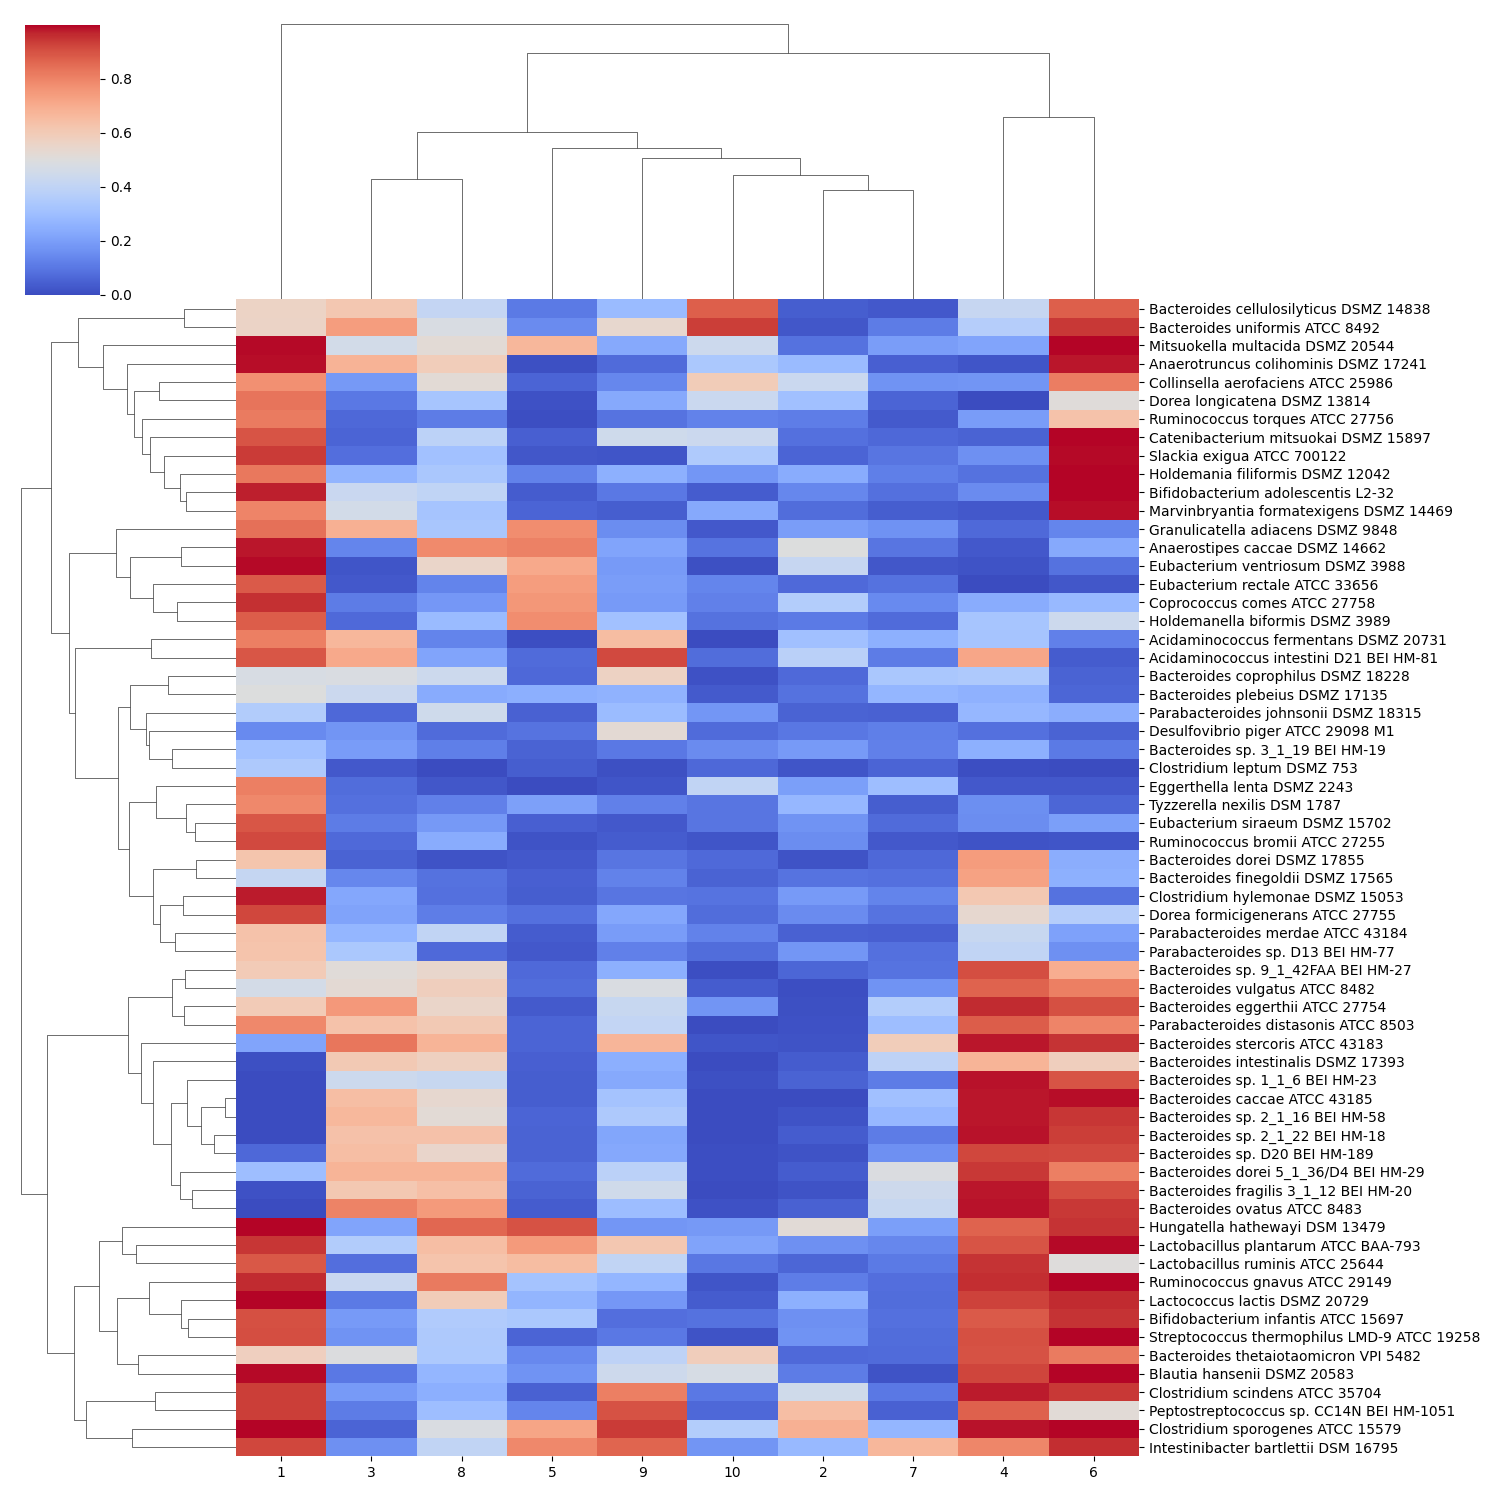

In [26]:
plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

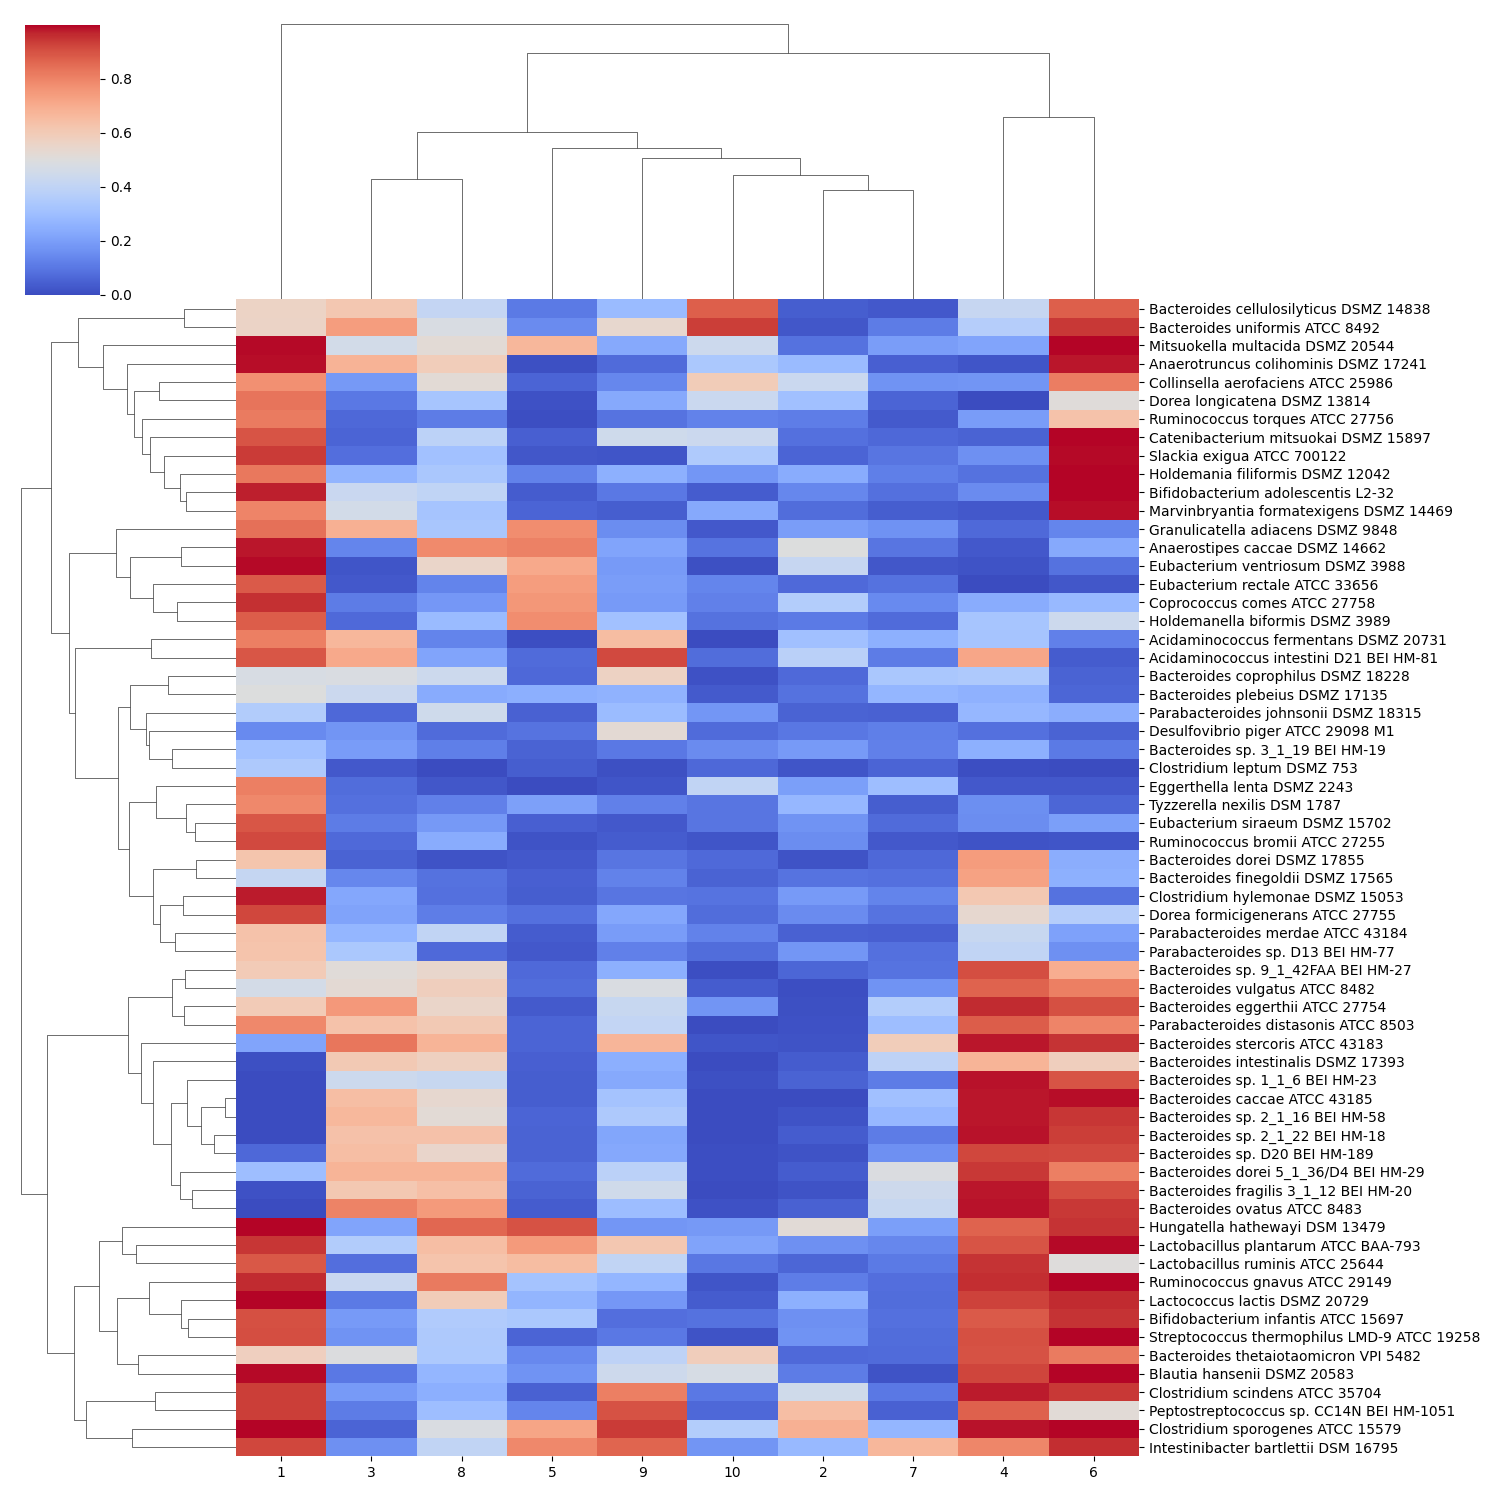

In [27]:
plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

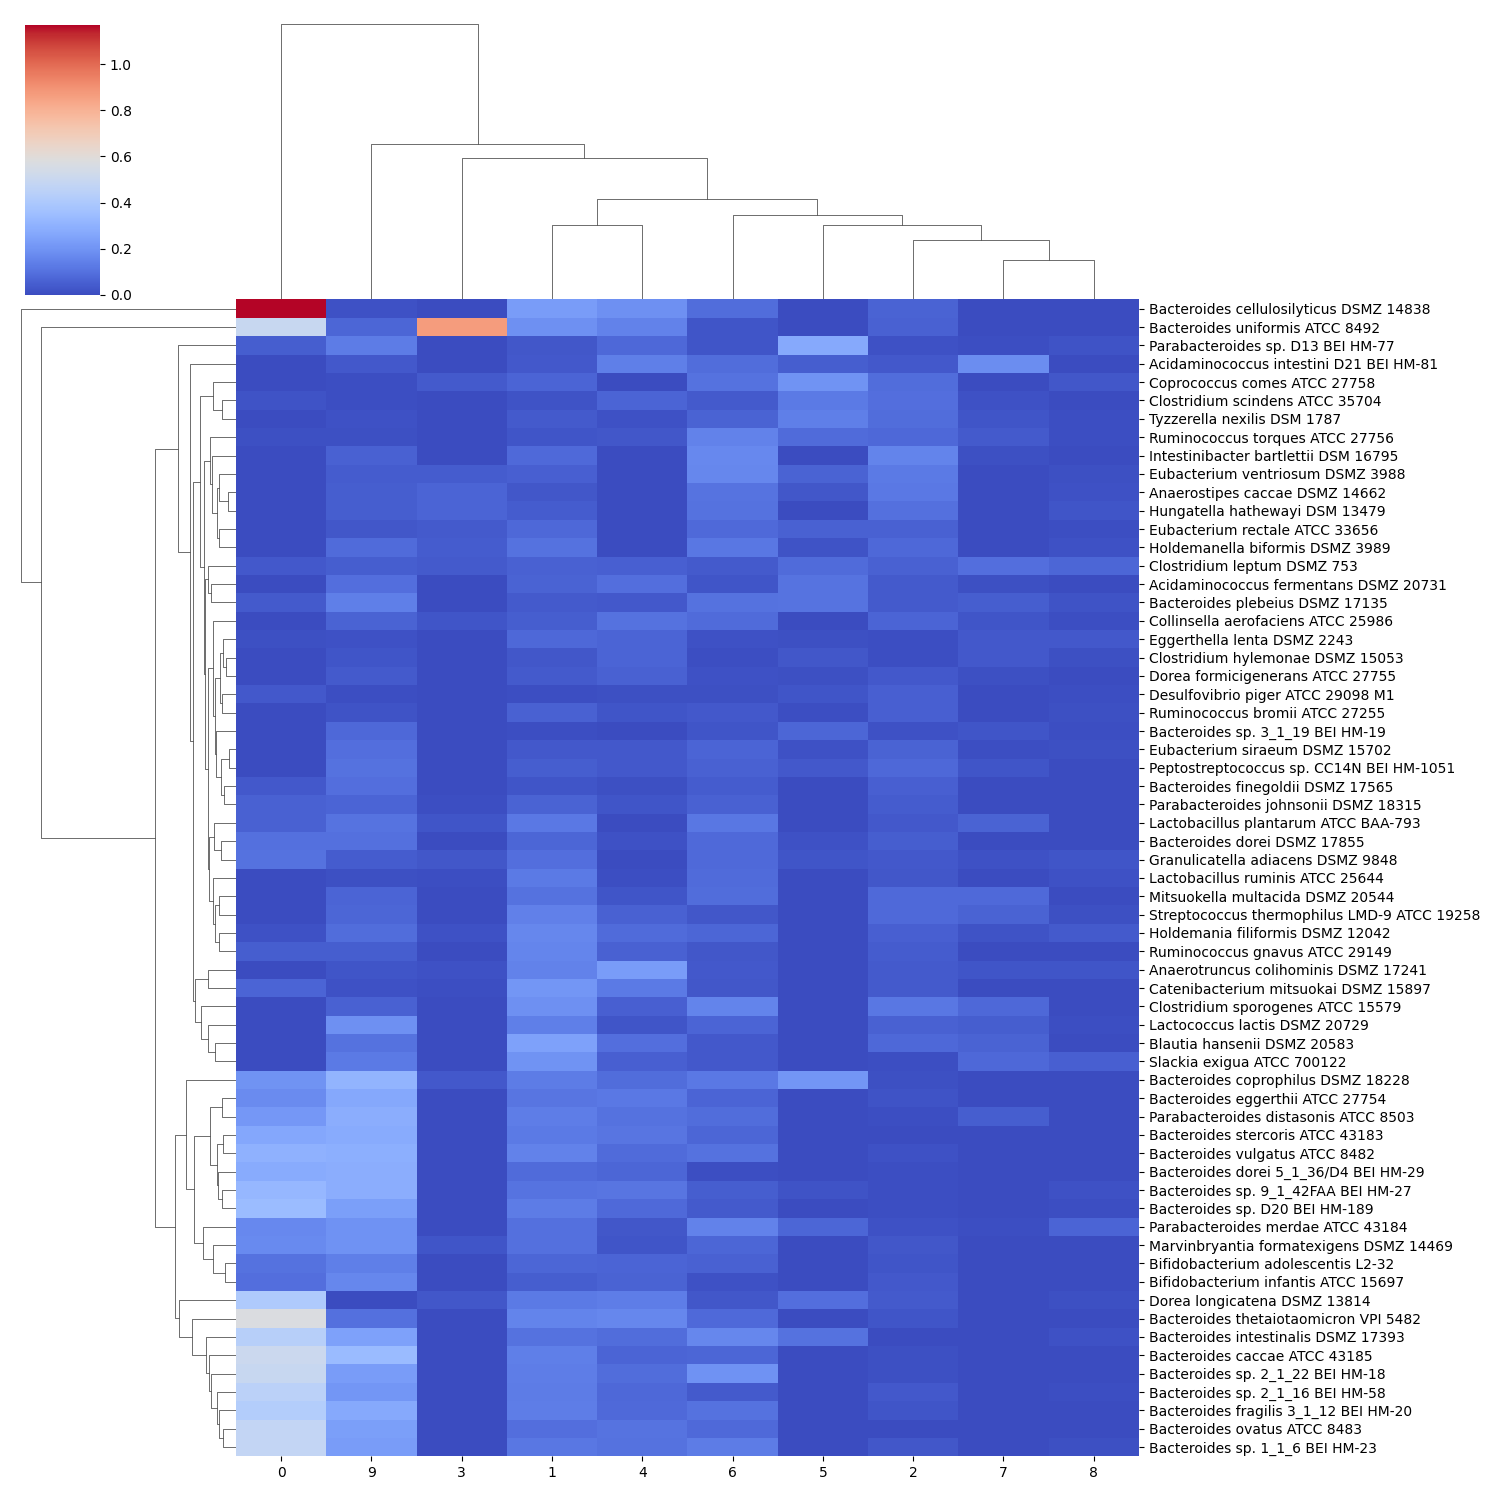

In [28]:
df_tmp = df_speciesMetab_prod_cluster.copy()
for col_ in df_tmp.columns.values:
    df_tmp[col_] = np.log10(1 + df_tmp[col_].values)
plt_ = sns.clustermap(df_tmp.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

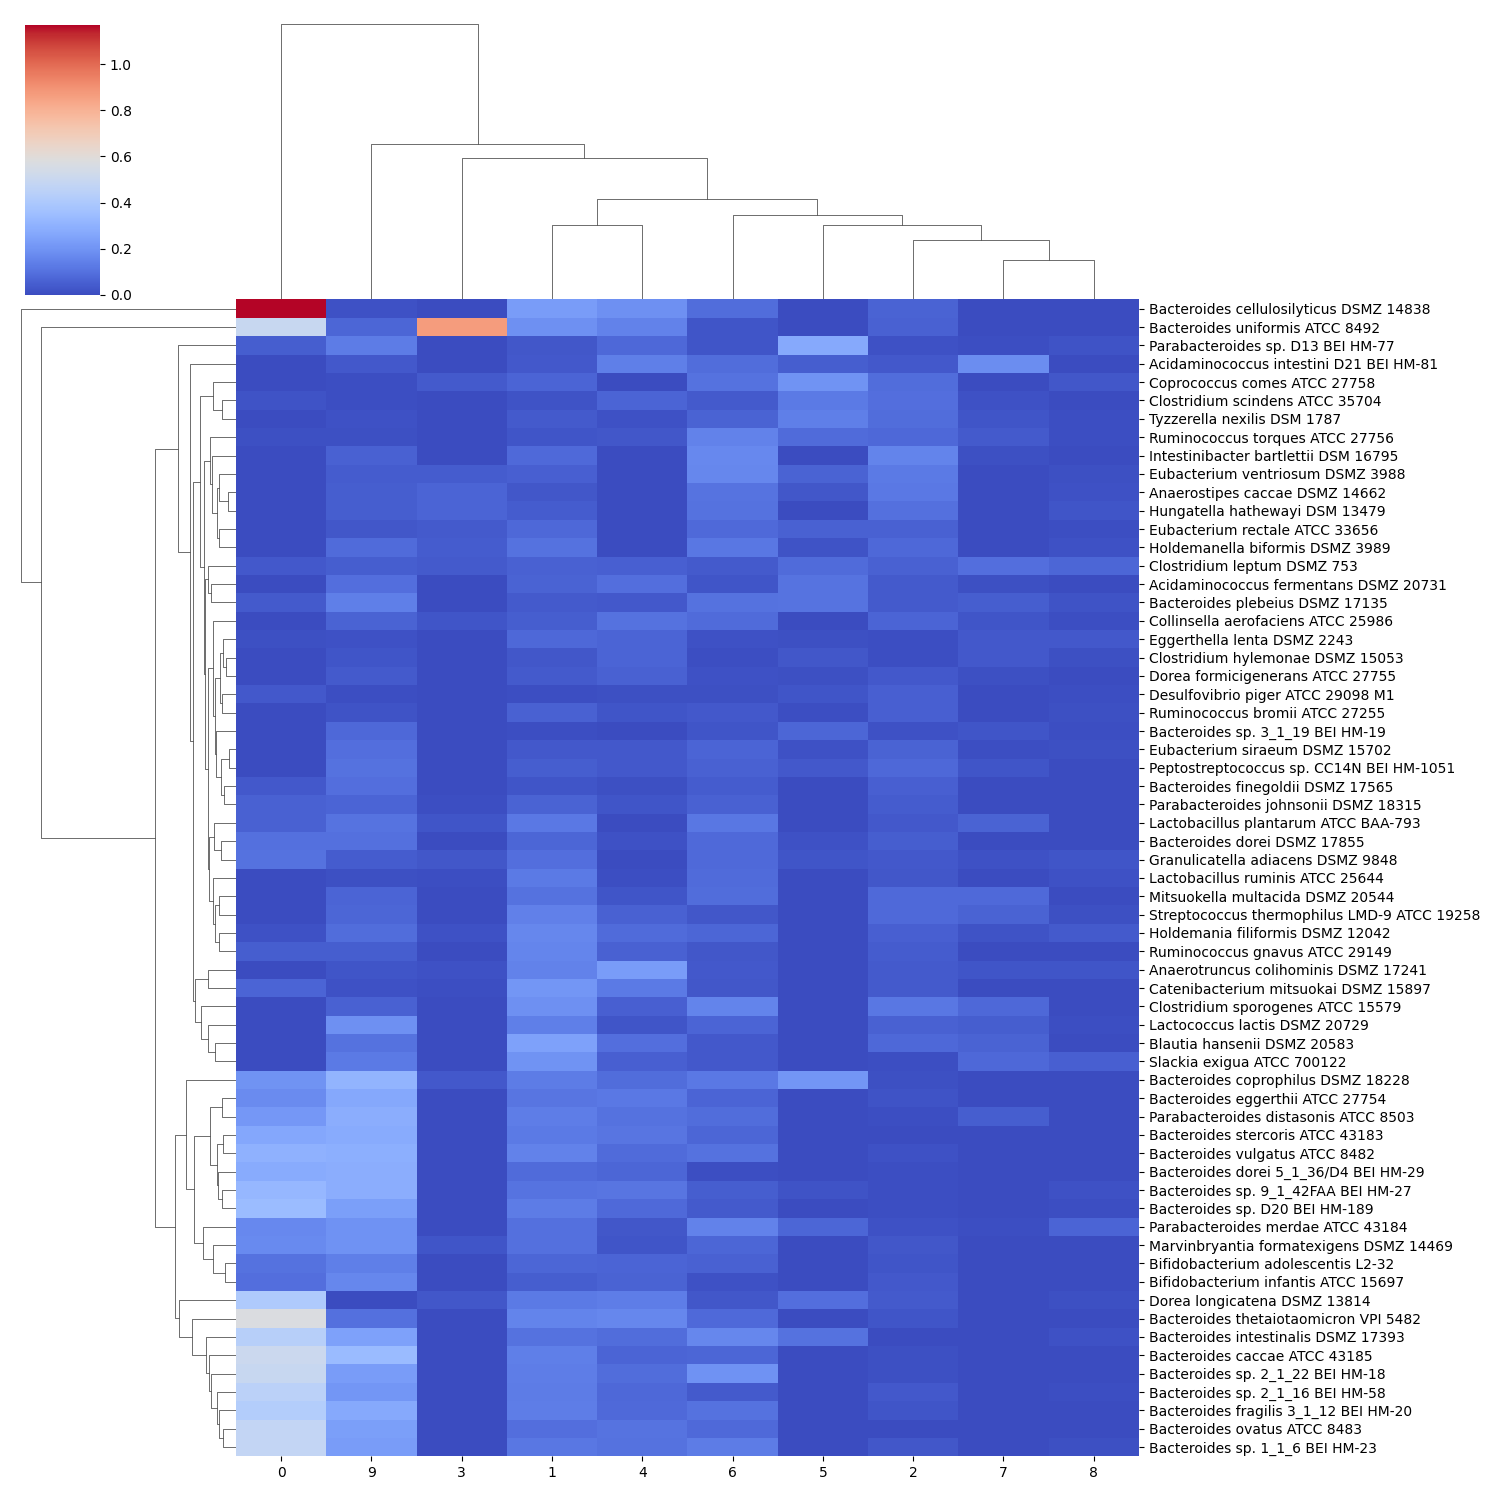

In [29]:
df_tmp = df_speciesMetab_prod_cluster.copy()
for col_ in df_tmp.columns.values:
    df_tmp[col_] = np.log10(1 + df_tmp[col_].values)
plt_ = sns.clustermap(df_tmp.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

In [30]:
df_metabs_clusters.iloc[92, :]
# df_metabs_clusters.shape

cluster_labels                         92
cluster_counts                          1
cluster_metab_IDs                   [218]
cluser_metab_names    [PYROGLUTAMIC ACID]
Name: 92, dtype: object

In [31]:
# normalized clustering
df_metabs_clusters.iloc[range(nclusts), :]

,cluster_labels,cluster_counts,cluster_metab_IDs,cluser_metab_names
0,0,5,"[70, 72, 114, 125, 134]","[5'-METHYLTHIOADENOSINE, ADENINE, NICOTINAMIDE..."
1,1,25,"[1, 6, 7, 24, 48, 62, 64, 66, 78, 83, 86, 90, ...","[NICOTINIC ACID, 1-METHYL-HYDANTOIN, SUCCINIC ..."
2,2,30,"[0, 16, 25, 26, 28, 30, 37, 38, 40, 41, 43, 46...","[N-METHYL-ASPARTIC ACID_0, STEARIC ACID, CITRI..."
3,3,5,"[35, 80, 93, 95, 106]","[3-UREIDOPROPIONATE, ASPARAGINE, GLUTAMINE, GL..."
4,4,15,"[5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 82, 85...","[BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,..."
5,5,5,"[15, 73, 96, 100, 135]","[1-METHYLADENOSINE, ADENOSINE, GUANOSINE, INOS..."
6,6,24,"[10, 12, 14, 31, 33, 36, 42, 44, 50, 51, 52, 5...","[CARNITINE, PHOSPHOCHOLINE, TRYPTOPHAN ETHYL E..."
7,7,7,"[3, 27, 34, 39, 65, 99, 110]","[MANNOSE 6-PHOSPHATE, GLUCOSE, SUCROSE_1, GLYC..."
8,8,6,"[4, 8, 63, 79, 84, 126]","[THREONINE_0, CINNAMALDEHYDE, 1-AMINOCYCLOPROP..."
9,9,14,"[2, 9, 11, 17, 21, 29, 32, 49, 58, 60, 61, 75,...","[OLEIC ACID, SPERMIDINE, AMINO(4-HYDROXYCYCLOH..."


# fit Ri dynamic for passage 1 -> 2 transition

In [32]:
df_speciesAbun_sim = pd.DataFrame()
header_new = create_abundance_header_new(num_bioRep=3, num_passages=7)
count_ = 0
for rep_ in np.arange(3):
    for pass_ in np.arange(7):
        if pass_ == 0:
            df_speciesAbun_sim[header_new[count_]] = (1 / num_species) * np.ones(num_species)
#             df_speciesAbun_sim[header_new[count_]] = \
#                 df_speciesAbun_inoc.iloc[:, 0].values
        else:
            df_speciesAbun_sim[header_new[count_]] = \
                df_speciesAbun_mdl.iloc[:, (pass_ - 1) + 6 * rep_].values
        count_ += 1

In [33]:
df_speciesAbun_ratio_sim = pd.DataFrame()
df_speciesAbun_prev_sim = pd.DataFrame()
df_speciesAbun_next_sim = pd.DataFrame()
count_ = 0
num_bioRep = 3
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'])
reps_ = np.array(['r0', 'r1', 'r2'])
brep_vec = list(range(num_bioRep))
thresh_zero = 1e-8
for rep_ in reps_:
    for pass_ in range(1, len(passages_)):
        col_1 = passages_[pass_ - 1] + "_" + rep_
        col_2 = passages_[pass_] + "_" + rep_

        df_speciesAbun_prev_sim[col_2] = df_speciesAbun_sim[col_1].values
        df_speciesAbun_next_sim[col_2] = df_speciesAbun_sim[col_2].values

        array_1 = np.array(df_speciesAbun_sim[col_2].values / df_speciesAbun_sim[col_1].values)
        array_2 = np.array(df_speciesAbun_sim[col_2].values)
        array_3 = np.array(df_speciesAbun_sim[col_1].values)
        df_speciesAbun_ratio_sim[col_2] = array_1.copy()
        id_ = np.where((array_3 == thresh_zero) & (array_2 == thresh_zero))[0]
#         id_ = np.where((array_2 == thresh_zero))[0]
#         id_ = np.where(array_1 == 1)[0]

        if len(id_) > 0:
            df_speciesAbun_ratio_sim.iloc[id_, count_] = -1
            rep_alt = list(set(reps_) - set([rep_]))
            ratio_vec = []
            for id_tmp in id_:
                abun_alt_ratio = []
                for rep__ in rep_alt:
                    col_1_ = passages_[pass_ - 1] + "_" + rep__
                    col_2_ = passages_[pass_] + "_" + rep__
                    val_1 = df_speciesAbun_sim[col_1_].values[id_tmp]
                    val_2 = df_speciesAbun_sim[col_2_].values[id_tmp]
                    if (val_1 != thresh_zero) | (val_2 != thresh_zero):
                        abun_alt_ratio.append(val_2 / val_1)

        count_ += 1

In [34]:
df_speciesAbun_sim

,p1_r0,p2_r0,p3_r0,p4_r0,p5_r0,p6_r0,p7_r0,p1_r1,p2_r1,p3_r1,...,p5_r1,p6_r1,p7_r1,p1_r2,p2_r2,p3_r2,p4_r2,p5_r2,p6_r2,p7_r2
0,0.015873,3.180398e-02,1.232587e-04,6.704587e-06,1.964384e-05,2.923860e-04,6.674918e-04,0.015873,3.751642e-02,1.509550e-04,...,3.247537e-03,2.649064e-02,6.867454e-03,0.015873,4.710307e-02,6.802839e-04,2.546092e-04,1.037398e-04,1.317724e-04,2.793396e-04
1,0.015873,2.174619e-01,2.143392e-01,3.034948e-01,2.783072e-01,2.449287e-01,2.852345e-01,0.015873,2.173035e-01,1.983694e-01,...,3.043407e-01,2.476548e-01,2.650648e-01,0.015873,1.584982e-01,2.045056e-01,2.981957e-01,3.043595e-01,3.054243e-01,2.736223e-01
2,0.015873,3.053745e-02,7.893345e-02,4.178763e-02,1.553076e-02,2.513826e-02,7.685045e-03,0.015873,3.393580e-02,9.603154e-03,...,1.700029e-02,2.282783e-02,6.528065e-03,0.015873,3.420288e-02,4.933659e-03,1.727806e-02,7.776625e-03,6.220632e-02,8.449614e-03
3,0.015873,7.641646e-05,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,0.015873,9.158013e-05,1.277543e-06,...,1.000000e-08,8.028099e-08,1.000000e-08,0.015873,7.865395e-05,7.965272e-07,1.000000e-08,1.000000e-08,1.000000e-08,1.575602e-07
4,0.015873,7.633257e-02,2.583468e-05,3.153010e-06,3.753517e-06,2.028774e-06,2.470496e-06,0.015873,7.271956e-02,4.145522e-05,...,6.430825e-06,1.331149e-06,1.814534e-06,0.015873,6.615639e-02,1.118852e-04,1.638908e-04,2.938171e-06,5.076057e-06,2.018581e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.015873,2.173690e-03,2.872359e-02,6.526354e-03,3.918121e-03,4.421267e-03,5.849030e-03,0.015873,2.753382e-03,1.592495e-02,...,5.560732e-03,6.711834e-03,1.701515e-03,0.015873,3.988645e-03,9.989043e-03,3.268566e-03,2.781552e-03,6.712029e-03,5.861230e-03
59,0.015873,2.727114e-04,9.021892e-05,2.965475e-06,4.094933e-06,1.882528e-05,1.090201e-05,0.015873,2.477832e-04,3.475236e-05,...,1.792223e-05,6.581487e-05,4.976816e-05,0.015873,2.444333e-04,3.758673e-05,4.198384e-05,3.080377e-05,1.010013e-05,8.941000e-05
60,0.015873,1.776472e-03,2.920661e-03,1.421295e-03,2.227100e-03,1.239252e-03,9.714653e-04,0.015873,1.821668e-03,2.737841e-03,...,7.986064e-04,3.016710e-04,3.447447e-04,0.015873,2.231052e-03,2.531160e-03,3.458196e-03,4.025108e-03,1.840863e-03,1.107381e-03
61,0.015873,3.879986e-07,1.000000e-08,8.662693e-08,1.000000e-08,1.000000e-08,1.000000e-08,0.015873,6.177283e-07,1.000000e-08,...,1.459906e-07,1.000000e-08,1.000000e-08,0.015873,8.277804e-07,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08


In [35]:
pass_keep = remove_passages(pass_rm_list=[0, 1, 3, 4, 5])
abun_avg_pass_3 = np.array(df_speciesAbun_mdl.iloc[:, pass_keep])
abun_avg_pass_3 = 10**np.mean(np.log10(abun_avg_pass_3), axis=1)

In [36]:
species_names_abbr = []
for species_ in species_names:
    tmp = species_.split("-")
    out_ = f'{tmp[0][:1]}. {tmp[1]}'
    species_names_abbr.append(out_)
species_names_abbr[7] = f'{species_names_abbr[7]} 5-1-36-D4'
species_names_abbr[8] = f'{species_names_abbr[8]} DSM-17855'
species_names_abbr[11] = f'{species_names_abbr[11]} 3-1-12'
species_names_abbr[16] = f'{species_names_abbr[16]} 2-1-16'
species_names_abbr[17] = f'{species_names_abbr[17]} 2-1-22'
species_names_abbr[18] = f'{species_names_abbr[18]} 3-1-19'
species_names_abbr[19] = f'{species_names_abbr[19]} 9-1-42FAA'
species_names_abbr[20] = f'{species_names_abbr[20]} D2'
species_names_abbr[55] = f'{species_names_abbr[55]} D13'
species_names_abbr[56] = f'{species_names_abbr[56]} CC14N-HM-1051'
species_names_abbr = np.array(species_names_abbr, dtype=object)

In [37]:
species_names_abbr

array(['A. fermentans', 'A. intestini', 'A. caccae', 'A. colihominis',
       'B. caccae', 'B. cellulosilyticus', 'B. coprophilus',
       'B. dorei 5-1-36-D4', 'B. dorei DSM-17855', 'B. eggerthii',
       'B. finegoldii', 'B. fragilis 3-1-12', 'B. intestinalis',
       'B. ovatus', 'B. plebeius', 'B. thetaiotaomicron',
       'B. fragilis 2-1-16', 'B. sp 2-1-22', 'B. sp 3-1-19',
       'B. sp 9-1-42FAA', 'B. sp D2', 'B. stercoris',
       'B. thetaiotaomicron', 'B. uniformis', 'B. vulgatus',
       'B. adolescentis', 'B. longum', 'B. hansenii', 'C. mitsuokai',
       'C. hylemonae', 'C. leptum', 'C. scindens', 'C. sporogenes',
       'C. aerofaciens', 'C. comes', 'D. piger', 'D. formicigenerans',
       'D. longicatena', 'E. lenta', 'E. rectale', 'E. siraeum',
       'E. ventriosum', 'G. adiacens', 'H. biformis', 'H. filiformis',
       'H. hathewayi', 'I. bartlettii', 'L. plantarum', 'L. ruminis',
       'L. lactis', 'M. formatexigens', 'M. multacida', 'P. distasonis',
       'P. joh

In [36]:
df_strains_abbr = pd.DataFrame(data={'Strain Abbr.' : species_names_abbr, \
                                     'Strain' : species_names})
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', \
                                        'jin_pollard'))
df_strains_abbr.to_csv(os.path.abspath(os.path.join(save_dir, \
                                                    f'species_names_abbr.csv')), \
                                                        index=False)

In [37]:
df_strains_abbr

,Strain Abbr.,Strain
0,A. fermentans,Acidaminococcus-fermentans-DSM-20731
1,A. intestini,Acidaminococcus-intestini-D21
2,A. caccae,Anaerostipes-caccae-DSM-14662
3,A. colihominis,Anaerotruncus-colihominis-DSM-17241
4,B. caccae,Bacteroides-caccae-ATCC-43185
...,...,...
58,R. gnavus,Ruminococcus-gnavus-ATCC-29149
59,R. torques,Ruminococcus-torques-ATCC-27756
60,S. exigua,Slackia-exigua-ATCC-700122
61,S. thermophilus,Streptococcus-thermophilus-LMD-9


## first fit Ri without productiion

In [39]:
## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
date_ = '20231207'
date_meeting = '20231207'


n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.1]


num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_with_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
num_passages = 7
pass_keep = np.arange(num_passages - 1)
id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + \
    list(pass_keep + 2 * (num_passages - 1))
pass_rm = [0, 2, 3, 4, 5]
Ri_dynamic_obj, A_train, b_train = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                df_speciesAbun_prev_sim, \
                                df_speciesAbun_next_sim, \
                                df_speciesAbun_ratio_sim, p_vec_new, \
                                file_save, num_passages=6, pass_rm=pass_rm, num_brep=3, \
                                get_prod=True, B_alone=0.1, \
                                df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                                prod_use_prev=False, use_dilution_term=True, \
                                dilution_factor=15000, use_avg_for_prod=False, \
                                return_raw_data=True, check_ratio_dir=False)
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, p_vec_new, \
#                                       file_save, num_passages=5, pass_rm=[3, 4])
# Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, \
#                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
# Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
#                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                        df_speciesAbun_ratio_mdl, \
#                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_) 

count = 0, p_tmp = 0.1


In [40]:
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy()

count_p = 0
Ri_0_init_new = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()

In [41]:
Ri_0_init_new

array([0.00000000e+00, 1.07537698e-02, 4.07832562e-02, 0.00000000e+00,
       3.65961006e-02, 0.00000000e+00, 0.00000000e+00, 5.37598242e-02,
       0.00000000e+00, 0.00000000e+00, 1.41583165e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.18766912e-02,
       4.98271520e-03, 0.00000000e+00, 0.00000000e+00, 2.74332530e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.39704804e-02, 5.69470577e-03, 4.45851933e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.80305770e-03, 5.40031592e-05, 0.00000000e+00, 0.00000000e+00,
       9.96736277e-03, 4.66976227e-02, 1.04520444e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.90621610e-04, 0.00000000e+00,
       0.00000000e+00, 1.45070281e-04, 0.00000000e+00, 0.00000000e+00,
       5.09814976e-04, 0.00000000e+00, 0.00000000e+00, 1.45082259e-02,
       3.42552410e-03, 2.85853486e-03, 0.00000000e+00, 0.00000000e+00,
      

In [42]:
# fit Ri with production and iteratively find B_alone
num_iter = 100
B_alone_iter = {}

## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs

date_ = '20231207'
date_meeting = '20231207'


rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.1]

n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
count_p = 0
p_vec_new_tmp = [p_vec_new[count_p]]


num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_with_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'_iterate_Balone.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
num_passages = 7
pass_keep = np.arange(num_passages - 1)
id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
pass_rm = [0, 2, 3, 4, 5]

RMSE_Balone_iterate = {}
id_species_keep = np.arange(df_speciesAbun_mdl.shape[0])

for iter_ in range(num_iter):
    print(f'iteration = {iter_}')
    if iter_ == 0:
#         B_alone_cur = np.median(abun_alone)
        Ri_avg = Ri_0_init_new.copy()
        B_alone_cur = get_B_alone_func(Ri_avg, \
                                       df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
#         B_alone_cur = 0.1 * np.ones(num_species)
    else:
        Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy()
        B_alone_cur = B_alone_iter[iter_ - 1].copy()
    
    
    Ri_dynamic_obj, A_train, b_train = fit_dynamic_Ri(df_speciesMetab_tmp.iloc[id_species_keep, :], \
                                    df_speciesAbun_prev_sim.iloc[:, id_keep], \
                                    df_speciesAbun_next_sim.iloc[:, id_keep], \
                                    df_speciesAbun_ratio_sim.iloc[:, id_keep], p_vec_new_tmp, \
                                    file_save, num_passages=6, pass_rm=pass_rm, save_data=False, \
                                    num_brep=3, \
                                    get_prod=True, B_alone=B_alone_cur, \
                                    df_speciesMetab_prod=df_speciesMetab_prod_tmp.iloc[id_species_keep, :], \
                                    prod_use_prev=False, use_avg_for_prod=False, \
                                    return_raw_data=True, check_ratio_dir=False)
    Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy()
#     a_tmp, A_mat, b_vec = fit_dynamic_Ri(df_speciesMetab_tmp, \
#                                     df_speciesAbun_prev_sim.iloc[:, id_keep], \
#                                     df_speciesAbun_next_sim.iloc[:, id_keep], \
#                                     df_speciesAbun_ratio_sim.iloc[:, id_keep], p_vec_new_tmp, \
#                                     file_save, num_passages=6, pass_rm=pass_rm, save_data=False, \
#                                     num_brep=3, \
#                                     get_prod=False, B_alone=B_alone_cur, \
#                                     df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
#                                     prod_use_prev=False, use_avg_for_prod=True, \
#                                     return_raw_data=True, check_ratio_dir=False, \
#                                         mode_Ri=False, Ri=Ri_avg.copy())
    
#     abun_alone_tmp = np.zeros((num_species))

#     for species_ in range(num_species):
#         abun_alone_tmp[species_] = np.sum(Ri_avg[0] * np.array(df_speciesMetab_cluster.iloc[species_, :].values))
    B_alone_iter[iter_] = get_B_alone_func(Ri_avg, \
                                           df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
#     B_alone_iter[iter_] = 1 / (a_tmp['Ri_noMicrocosm_dynamicAll_fit_joint'][0] + 1e-10)
    RMSE_Balone_iterate[iter_] = \
        get_RMSE_Balone_func(df_speciesMetab_cluster.iloc[id_species_keep, :], \
                             df_speciesMetab_prod_cluster.iloc[id_species_keep, :], \
                             p_vec_new_tmp, 0, \
                        Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy(), \
                        df_speciesAbun_inoc.iloc[id_species_keep, :], \
                             df_speciesAbun_mdl, df_speciesAbun_prev_mdl, \
                        df_speciesAbun_ratio_mdl, B_alone_cur, num_passages=6, \
                        use_dilution=True)
Ri_dynamic_obj['B_alone_iter'] = B_alone_iter
# with open(file_save, "wb") as file_:
#      pickle.dump(Ri_dynamic_obj, file_) 

iteration = 0
count = 0, p_tmp = 0.1
iteration = 1
count = 0, p_tmp = 0.1
iteration = 2
count = 0, p_tmp = 0.1
iteration = 3
count = 0, p_tmp = 0.1
iteration = 4
count = 0, p_tmp = 0.1
iteration = 5
count = 0, p_tmp = 0.1
iteration = 6
count = 0, p_tmp = 0.1
iteration = 7
count = 0, p_tmp = 0.1
iteration = 8
count = 0, p_tmp = 0.1
iteration = 9
count = 0, p_tmp = 0.1
iteration = 10
count = 0, p_tmp = 0.1
iteration = 11
count = 0, p_tmp = 0.1
iteration = 12
count = 0, p_tmp = 0.1
iteration = 13
count = 0, p_tmp = 0.1
iteration = 14
count = 0, p_tmp = 0.1
iteration = 15
count = 0, p_tmp = 0.1
iteration = 16
count = 0, p_tmp = 0.1
iteration = 17
count = 0, p_tmp = 0.1
iteration = 18
count = 0, p_tmp = 0.1
iteration = 19
count = 0, p_tmp = 0.1
iteration = 20
count = 0, p_tmp = 0.1
iteration = 21
count = 0, p_tmp = 0.1
iteration = 22
count = 0, p_tmp = 0.1
iteration = 23
count = 0, p_tmp = 0.1
iteration = 24
count = 0, p_tmp = 0.1
iteration = 25
count = 0, p_tmp = 0.1
iteration = 26
count =

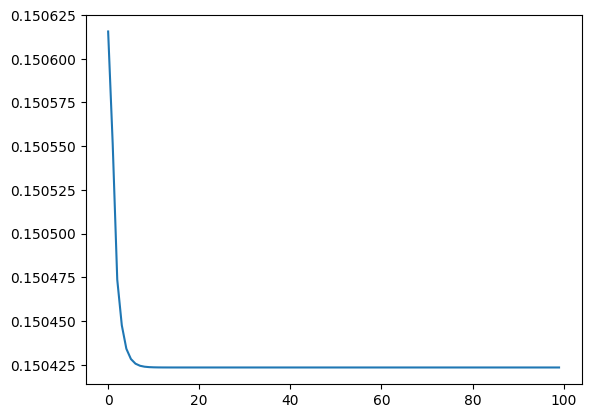

In [43]:
num_iter = 100
vals_ = np.zeros(num_iter)
id_ = 1
for iter_ in range(num_iter):
    vals_[iter_] = (B_alone_iter[iter_][id_])
plt_ = sns.lineplot(x=range(num_iter), y=vals_)

In [44]:
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']
B_alone_iter = Ri_dynamic_obj['B_alone_iter']

In [45]:
# evalute Ri with production and iterative Balone
date_ = '20231207'
date_meeting = '20231207'

num_iter = 100
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
count_p = 7
# num_iter = 20
p_vec_new_tmp = [p_vec_new[count_p]]
count_p = 0

RMSE_mat_full = np.zeros((num_passages - 1, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# Ri_fit = {0: Ri_pass1.copy()}
# Ri_0 = {0: Ri_inoc.copy()}
abun_alone = get_B_alone_func(Ri_avg, df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all_prod, RMSE_obj_all_prod = \
    blindly_pred_abun_growth([p_vec_new_tmp[count_p]], \
                             df_speciesMetab_tmp.iloc[id_species_keep, :], \
                             df_speciesAbun_inoc.iloc[id_species_keep, :].copy(), \
                             df_speciesAbun_mdl.copy(), \
                             df_speciesAbun_prev_mdl.copy(), \
                             df_speciesAbun_ratio_mdl.copy(), \
                             Ri_fit.copy(), "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True, \
                             get_prod=True, B_alone=B_alone_iter[num_iter - 2].copy(), \
                             df_speciesMetab_prod=df_speciesMetab_prod_tmp.iloc[id_species_keep, :], \
                             prod_use_prev=False, use_dilution=True, dilution_factor=15000, \
                             use_avg_for_prod=False, Ri_0=None)
for pass_ in range(num_passages - 1):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all_prod[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all_prod[pass_]["growth_ratio"]

In [59]:
RMSE_mat_full

array([[1.31572364, 1.28449711],
       [1.52275768, 0.96130453],
       [1.68253271, 0.96920485],
       [1.9096714 , 1.14403306],
       [2.14519626, 1.03872027],
       [2.39752488, 1.0254584 ]])

In [46]:
RMSE_mat_full

array([[1.37872759, 1.35077109],
       [1.51271821, 0.89922494],
       [1.77124421, 1.22630656],
       [2.01500362, 1.40132649],
       [2.27557446, 1.33840186],
       [2.48713209, 1.33389063]])

In [63]:
len(sens_obj_all_prod[pass_]['df_speciesAbun_next_obs'].copy())

189

In [64]:
len(sens_obj_all_prod[pass_]['df_speciesAbun_next_pred'].copy())

189

row = 0, col = 0
RMSE high-mid abundance = 1.287879983593343
row = 0, col = 1
RMSE high-mid abundance = 0.8146386433371612
row = 0, col = 2
RMSE high-mid abundance = 1.3382395626215013


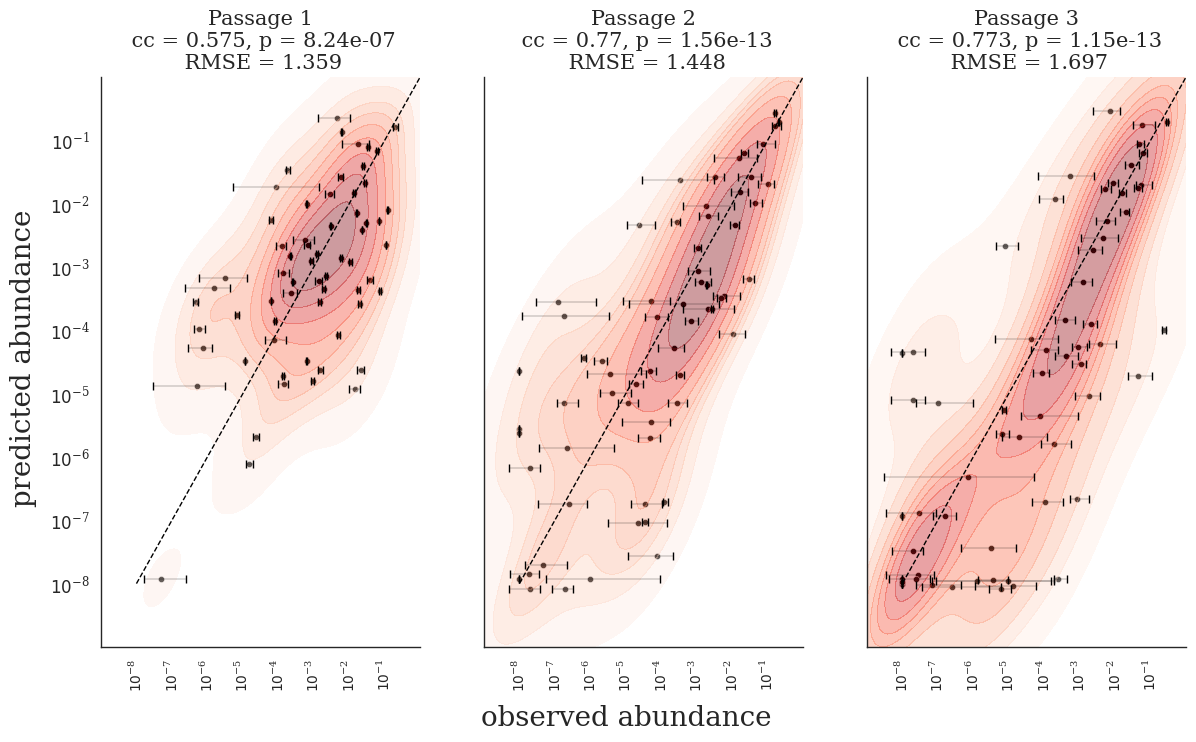

In [47]:
# Figure 2 for paper: prediction performance with production and iterative Balone

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 3, figsize=(14, 7.4), sharey="row", sharex="col")
fig.supylabel('predicted abundance', fontsize=20, x=0.06, y=0.5)
fig.supxlabel('observed abundance', fontsize=20, x=0.5, y=-0.005)
df_pred_vs_obs = pd.DataFrame(data={'passage' : [], \
                                    'species' : [], \
                                    'predicted_abundance' : [], \
                                    'mean_observed_abundance' : [], \
                                    'min_observed_abundance' : [], \
                                    'max_observed_abundance' : []})
max_to_min_pass = [None] * 3
abun_pred_pass = [None] * 3
abun_linear_pred_pass = [None] * 3
abun_orig_pass = [None] * 3
abun_orig_pass_rep = [None] * 3
sd_orig_pass = [None] * 3
RMSE_pred = [None] * 3
for pass_ in range(3):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x_f = sens_obj_all_prod[pass_]['df_speciesAbun_next_obs'].copy()
    x_f = x_f.flatten()
    y_f = sens_obj_all_prod[pass_]['df_speciesAbun_next_pred'].copy()
    thresh_zero = 1e-8
    y_f[y_f <= thresh_zero] = thresh_zero
    x_f[x_f <= thresh_zero] = thresh_zero

    x = np.zeros((num_species))
    x_min = np.zeros((num_species))
    x_max = np.zeros((num_species))
    y = np.zeros((num_species))
    sd_orig_pass[pass_] = np.zeros((num_species))
    RMSE_pred[pass_] = np.zeros((num_species))
    abun_linear_pred_pass[pass_] = np.zeros((num_species))
    abun_orig_pass_rep[pass_] = np.zeros((num_species, 3))
    for rep_ in range(3):
        id_ = np.arange(num_species) * 3 + rep_
        abun_orig_pass_rep[pass_][:, rep_] = np.log10(x_f[id_])
    for species_ in range(num_species):
        id_ = np.array([0, 1, 2]) + species_ * 3
        x[species_] = np.exp(np.mean(np.log(x_f[id_])))
        x_min[species_] = np.min(x_f[id_])
        x_max[species_] = np.max(x_f[id_])
        y[species_] = np.exp(np.mean(np.log(y_f[id_])))
        abun_linear_pred_pass[pass_][species_] = np.mean(x_f[id_])

        sd_orig_pass[pass_][species_] = np.sqrt(np.var((x_f[id_])))
        RMSE_pred[pass_][species_] = np.sqrt(np.mean(np.power(np.log10(x_f[id_]) - \
                                                    np.log10(y_f[id_]), 2)))
        
    x = np.log10(x)
    x_min = np.log10(x_min)
    x_max = np.log10(x_max)
    y = np.log10(y)
    y_orig = y.copy()
    
    id_filter = np.where(x >= -3)[0]
    # id_filter = np.arange(len(x))
    RMSE_tmp = np.sqrt(np.mean(np.power(y_orig[id_filter] - x[id_filter], 2)))
    print(f'RMSE high-mid abundance = {RMSE_tmp}')
    
    id_ = np.where(y <= -7.99)[0]
    noise_ = np.random.choice([-4, -3, -2, -1, 0, 1, 2, 3, 4], len(id_), replace=True)
    y[id_] += noise_ / 50
    
    df_pred_vs_obs_tmp = pd.DataFrame(data={'passage' : [pass_] * len(x), \
                                      'species' : species_names[:].flatten(), \
                                      'predicted_abundance (log10)' : y, \
                                      'mean_observed_abundance (log10)' : x, \
                                      'min_observed_abundance (log10)' : x_min, \
                                      'max_observed_abundance (log10)' : x_max})
    max_to_min_pass[pass_] = x_max.copy() - x_min.copy()
    abun_pred_pass[pass_] = y_orig.copy()
    abun_orig_pass[pass_] = x.copy()
    if pass_ == 0:
        df_pred_vs_obs = df_pred_vs_obs_tmp.copy()
    else:
        df_pred_vs_obs = pd.concat((df_pred_vs_obs, df_pred_vs_obs_tmp), axis=0)
    
    def error_bar_(x):
        return (np.min(x), np.max(x))

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=20, ax=axes[ax_col_], c="black")
    xerr=np.vstack([x_max.flatten() - x.flatten(), \
                    x.flatten() - x_min.flatten()])
    xerr[xerr < 0] = 0
    axes[ax_col_].errorbar(x=x, y=y, yerr=None, \
                                    xerr=xerr, \
                                   fmt='none', elinewidth=0.2, c="black", \
                          capsize=3)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.4, cmap="Reds", \
                    ax=axes[ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="black", linewidth=1, ls="dashed")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y_orig)
    corr_val_pe_log = scipy.stats.pearsonr(x, y_orig)
    corr_val_sp = scipy.stats.spearmanr(x, y_orig)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y_orig - x, 2)))
    std_error = np.sqrt(np.std(np.power(y_orig - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y_orig, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    title_ = f'Passage {pass_ + 1}' + \
            f'\n cc = {np.round(corr_val_pe_log[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe_log[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'
    # title_ = f'Passage {pass_ + 1}' + \
    #         f'\n cc = {np.round(corr_val_pe[0], 3)}, p = ' + \
    #                 '{:.2e}'.format(corr_val_pe[1]) + \
    #         f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_col_].set_title(title_, size=15)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        yticks_ = np.arange(-8, 0, step=1)
        ylabs_ = []
        for y_ in yticks_:
            ylabs_.append(fr"${10}^{{\mathregular{{{y_}}}}}$")
        plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=9)
    if ax_row_ == 0:
        xticks_ = np.arange(-8, 0, step=1)
        xlabs_ = []
        for x_ in xticks_:
            xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
        plt_.set_xticks(xticks_, labels=xlabs_, fontsize=10)
        axes[ax_col_].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[ax_col_].set_xlim(-9, 0)
    axes[ax_col_].set_ylim(-9, 0)
        
    plt_ = sns.despine(right=True, top=True, ax=axes[ax_col_])

In [66]:
len(sens_obj_all_prod[pass_]['growth_ratio_all'].copy().values.flatten())

63

In [71]:
sens_obj_all_prod[pass_]['growth_ratio_obs'].copy().flatten()

array([ 5.43944244e-02,  1.85616455e+00,  3.74268942e-01,  1.41595541e+00,
        1.34834510e+00,  1.45813026e+00,  5.29403280e-01,  3.27224348e+00,
        3.50207827e+00, -1.00000000e+00,  1.76685949e-01,  1.25544996e-02,
        1.22045668e-01,  1.15535462e-01,  1.46481173e+00,  2.89238782e-02,
        1.11982710e+01,  2.53324120e-02,  2.58969637e+00, -1.00000000e+00,
        1.62636482e+01,  3.91835233e+00,  1.97009344e+00,  8.53346463e-02,
        8.05282163e+00,  6.66548107e+00,  1.07173441e+01,  4.03045961e-01,
        1.87956618e-01,  4.64327669e-01,  2.82023787e+00,  2.12862812e+00,
        4.76119902e+00,  4.66024684e+00,  1.44486617e+00,  1.40723766e+00,
        4.13189186e-01,  9.99835749e-02,  2.18391414e-01,  1.14242516e+00,
        1.78215393e+00,  9.46709384e-01,  6.66770827e-01,  2.84650783e-01,
        1.72150749e-02,  3.55040533e+00,  5.77725965e+00,  3.87123797e+00,
        1.61192386e-01,  7.02209258e-01,  2.70241956e+00,  1.17762279e+00,
        3.36775768e+00,  

In [73]:
sens_obj_all_prod[0]['growth_ratio_obs'].copy().flatten()

array([4.03566466e+00, 2.68108240e+01, 7.45193521e-01, 1.50058132e-02,
       1.65987111e+00, 5.74164287e-01, 5.00868002e+00, 1.45795846e+00,
       8.26479994e-01, 2.88950761e-02, 1.47362660e-01, 4.60870274e-01,
       3.42494909e-01, 1.81395080e+00, 6.92525876e-02, 1.08838551e+00,
       2.57474439e+00, 2.47000323e-03, 7.25187998e-01, 1.94223398e+00,
       9.79837851e-01, 9.05802906e-01, 2.32865698e+00, 5.87853996e-01,
       2.12638309e-01, 8.19183711e-03, 7.89673478e-03, 4.29270554e-03,
       2.74639421e-04, 1.14076356e-01, 3.52048678e-03, 6.47048564e-01,
       2.82172010e-01, 1.73490596e-01, 2.07317086e-02, 1.10571521e-02,
       4.30013043e-01, 1.01058039e-04, 1.67812080e-01, 7.12344475e-02,
       5.73255895e-02, 1.49311374e-02, 1.35492897e-01, 5.34345524e-05,
       1.00096539e+00, 5.64947207e-01, 2.93800445e-02, 2.20770851e-03,
       7.34784124e+00, 4.89402613e+00, 5.68047724e-02, 5.79732361e-01,
       3.80356858e-01, 2.23134465e-01, 8.22727745e-02, 7.73850665e-01,
      

row = 0, col = 0
RMSE high-mid abundance = 1.2291070627074248
row = 0, col = 1
RMSE high-mid abundance = 1.0027727639341997
row = 0, col = 2
RMSE high-mid abundance = 0.9900047320247294


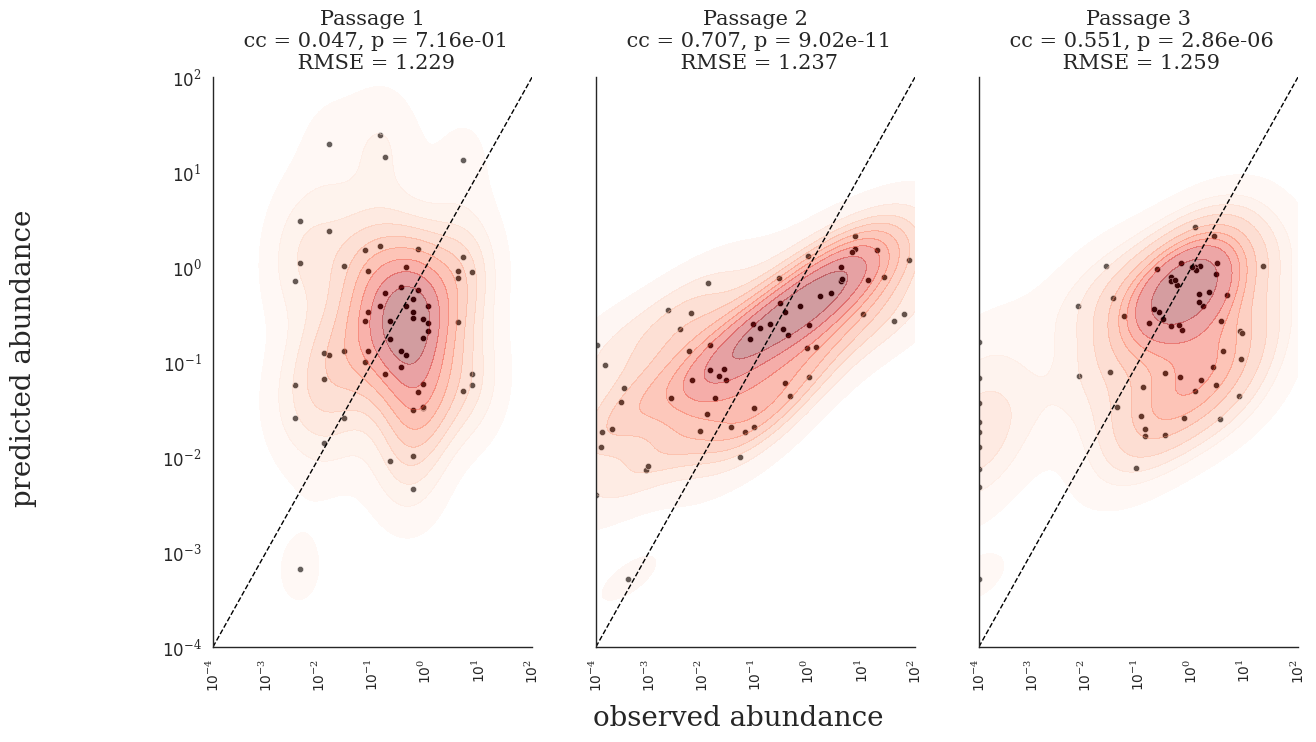

In [72]:
# Figure 2 for paper: prediction performance with production and iterative Balone

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 3, figsize=(14, 7.4), sharey="row", sharex="col")
# axes = [axes_all]
fig.supylabel('predicted abundance', fontsize=20, x=-0.02, y=0.5)
fig.supxlabel('observed abundance', fontsize=20, x=0.5, y=-0.005)
df_pred_vs_obs = pd.DataFrame(data={'passage' : [], \
                                    'species' : [], \
                                    'predicted_abundance' : [], \
                                    'mean_observed_abundance' : [], \
                                    'min_observed_abundance' : [], \
                                    'max_observed_abundance' : []})
num_passages_test = 3
n_breps_test = 1
n_breps_test1 = 3
max_to_min_pass = [None] * num_passages_test
abun_pred_pass = [None] * num_passages_test
abun_linear_pred_pass = [None] * num_passages_test
abun_orig_pass = [None] * num_passages_test
abun_orig_pass_rep = [None] * num_passages_test
sd_orig_pass = [None] * num_passages_test
RMSE_pred = [None] * num_passages_test
x_ratio = {}
for pass_ in range(num_passages_test):
    ax_row_ = int(pass_ / num_passages_test)
    ax_col_ = int(pass_ % num_passages_test)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(n_breps_test)
    x_f = sens_obj_all_prod[pass_]['growth_ratio_obs'].copy().flatten()
    x_f = x_f.flatten()
    x_ratio[pass_] = x_f.copy()
    y_f = sens_obj_all_prod[pass_]['growth_ratio_all'].copy().values.flatten()
    thresh_zero = 1e-4
    y_f[y_f <= thresh_zero] = thresh_zero
    x_f[x_f <= thresh_zero] = thresh_zero

    x = np.zeros((num_species))
    x_min = np.zeros((num_species))
    x_max = np.zeros((num_species))
    y = np.zeros((num_species))
    sd_orig_pass[pass_] = np.zeros((num_species))
    RMSE_pred[pass_] = np.zeros((num_species))
    abun_linear_pred_pass[pass_] = np.zeros((num_species))
    abun_orig_pass_rep[pass_] = np.zeros((num_species, 3))
    for rep_ in range(n_breps_test):
        id_ = np.arange(num_species) * n_breps_test + rep_
        abun_orig_pass_rep[pass_][:, rep_] = np.log10(x_f[id_])
    id_sp_tmp = []
    for species_ in range(num_species):
        # id_ = np.array([0, 1, 2]) + species_ * 3
        id_1 = np.array([0]) + species_ * n_breps_test1
        x_tmp = x_f[id_1]
        id_tmp = np.where(x_tmp > 0)[0]
        if len(id_tmp) > 0:
            id_sp_tmp.append(species_)
            x[species_] = np.exp(np.mean(np.log(x_tmp[id_tmp])))
            x_min[species_] = np.min(x_tmp[id_tmp])
            x_max[species_] = np.max(x_tmp[id_tmp])
            id_ = np.array([0]) + species_ * n_breps_test
            y[species_] = np.exp(np.mean(np.log(y_f[id_])))
            abun_linear_pred_pass[pass_][species_] = np.mean(x_tmp[id_tmp])

            sd_orig_pass[pass_][species_] = np.sqrt(np.var((x_tmp[id_tmp])))
        # RMSE_pred[pass_][species_] = np.sqrt(np.mean(np.power(np.log10(x_f[id_1]) - \
        #                                             np.log10(y_f[id_]), 2)))
    x = x[id_sp_tmp]
    x_min = x_min[id_sp_tmp]
    x_max = x_max[id_sp_tmp]
    y = y[id_sp_tmp]
    id_ = np.where(x > 0)[0]
    x = np.log10(x[id_])
    x_min = np.log10(x_min)
    x_max = np.log10(x_max)
    y = np.log10(y[id_])
    y_orig = y.copy()
    
    id_filter = np.where(x >= -3)[0]
    RMSE_tmp = np.sqrt(np.mean(np.power(y_orig[id_filter] - x[id_filter], 2)))
    print(f'RMSE high-mid abundance = {RMSE_tmp}')
    
    # id_ = np.where(y <= -7.99)[0]
    # noise_ = np.random.choice([-4, -3, -2, -1, 0, 1, 2, 3, 4], len(id_), replace=True)
    # y[id_] += noise_ / 50
    
    # df_pred_vs_obs_tmp = pd.DataFrame(data={'passage' : [pass_] * len(x), \
    #                                   'species' : species_names[:].flatten(), \
    #                                   'predicted_abundance (log10)' : y, \
    #                                   'mean_observed_abundance (log10)' : x, \
    #                                   'min_observed_abundance (log10)' : x_min, \
    #                                   'max_observed_abundance (log10)' : x_max})
    max_to_min_pass[pass_] = x_max.copy() - x_min.copy()
    abun_pred_pass[pass_] = y_orig.copy()
    abun_orig_pass[pass_] = x.copy()
    # if pass_ == 0:
    #     df_pred_vs_obs = df_pred_vs_obs_tmp.copy()
    # else:
    #     df_pred_vs_obs = pd.concat((df_pred_vs_obs, df_pred_vs_obs_tmp), axis=0)
    
    def error_bar_(x):
        return (np.min(x), np.max(x))

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=20, ax=axes[ax_col_], c="black")
    xerr=np.vstack([x_max.flatten() - x.flatten(), \
                    x.flatten() - x_min.flatten()])
    xerr[xerr < 0] = 0
    # axes[ax_col_].errorbar(x=x, y=y, yerr=None, \
    #                                 xerr=xerr, \
    #                                fmt='none', elinewidth=0.2, c="black", \
    #                       capsize=3)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.4, cmap="Reds", \
                    ax=axes[ax_col_])
    plt_.plot([-4, 2], [-4, 2], c="black", linewidth=1, ls="dashed")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y_orig)
    corr_val_pe_log = scipy.stats.pearsonr(x, y_orig)
    corr_val_sp = scipy.stats.spearmanr(x, y_orig)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y_orig - x, 2)))
    std_error = np.sqrt(np.std(np.power(y_orig - x, 2)))

    id_notzero_zero = np.where((x > -4) & (y <= -4))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y_orig, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    title_ = f'Passage {pass_ + 1}' + \
            f'\n cc = {np.round(corr_val_pe_log[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe_log[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'
    # title_ = f'Passage {pass_ + 1}' + \
    #         f'\n cc = {np.round(corr_val_pe[0], 3)}, p = ' + \
    #                 '{:.2e}'.format(corr_val_pe[1]) + \
    #         f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_col_].set_title(title_, size=15)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        yticks_ = np.arange(-4, 3, step=1)
        ylabs_ = []
        for y_ in yticks_:
            ylabs_.append(fr"${10}^{{\mathregular{{{y_}}}}}$")
        plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=9)
    if ax_row_ == 0:
        xticks_ = np.arange(-4, 3, step=1)
        xlabs_ = []
        for x_ in xticks_:
            xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
#             plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
        plt_.set_xticks(xticks_, labels=xlabs_, fontsize=10)
        axes[ax_col_].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[ax_col_].set_xlim(-4, 2)
    axes[ax_col_].set_ylim(-4, 2)
        
    plt_ = sns.despine(right=True, top=True, ax=axes[ax_col_])

row = 0, col = 0
row = 0, col = 1
row = 0, col = 2


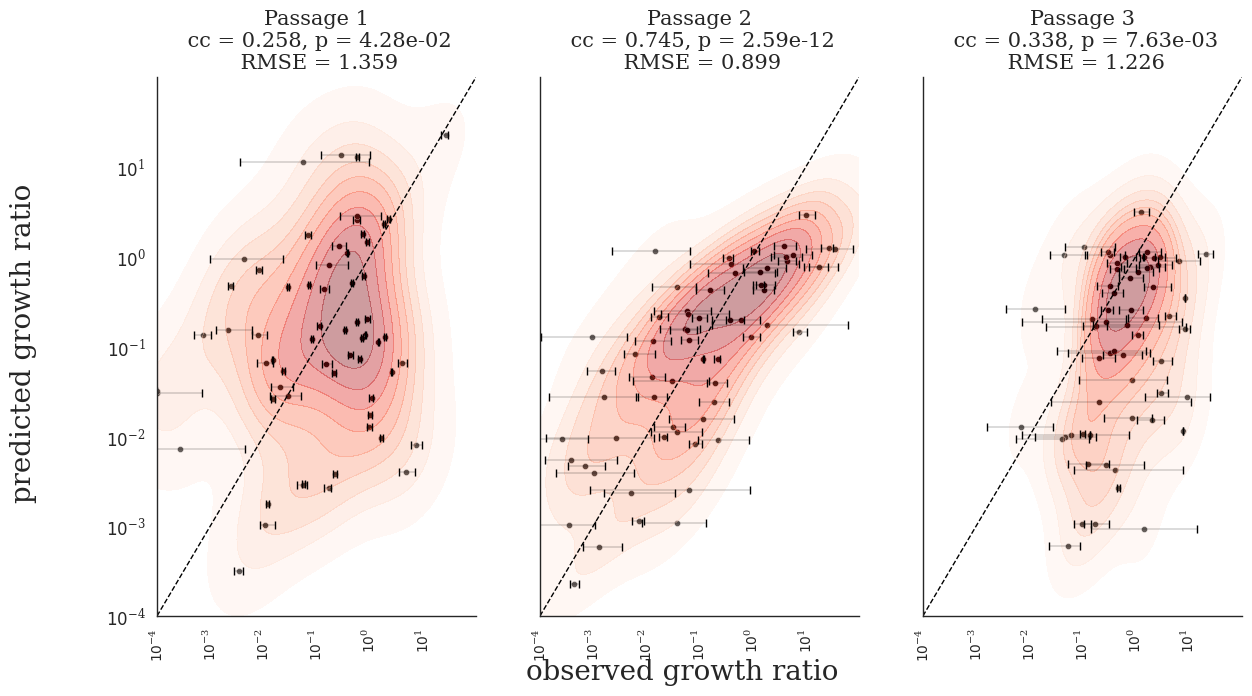

In [48]:
# Figure for paper: prediction performance with production and iterative Balone
date_ = '20230912'
date_meeting = '20230912'

date_ = '20230927'
date_meeting = '20230927'

date_ = '20231006'
date_meeting = '20231006'

date_ = '20231015'
date_meeting = '20231015'

date_ = '20231025'
date_meeting = '20231025'

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')

num_iter = 100
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
fig, axes = plt.subplots(1, 3, figsize=(14, 7), sharey="row", sharex="col")
fig.supylabel('predicted growth ratio', fontsize=20)
fig.supxlabel('observed growth ratio', fontsize=20)
df_pred_vs_obs = pd.DataFrame(data={'passage' : [], \
                                    'species' : [], \
                                    'predicted_abundance' : [], \
                                    'mean_observed_abundance' : [], \
                                    'min_observed_abundance' : [], \
                                    'max_observed_abundance' : []})
for pass_ in range(3):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x_f = sens_obj_all_prod[pass_]['growth_ratio_obs']
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    x_f = x_f.flatten()
    x_f_neg = x_f.copy()
    
    x_tmp = sens_obj_all_prod[pass_]['df_speciesAbun_next_obs']
    y_f = sens_obj_all_prod[pass_]['df_speciesAbun_next_pred'] / x_tmp
    thresh_zero = 1e-4
    y_f[y_f <= thresh_zero] = thresh_zero
    x_f[x_f <= thresh_zero] = thresh_zero
    
    if pass_ > 0:
        pass_tmp = pass_ - 1
        df_speciesAbun_ratio_tmp_1 = \
                df_speciesAbun_ratio_mdl.iloc[:, [pass_tmp, pass_tmp + 5, \
                                                         pass_tmp + 10]].copy()
#         abun_prev = np.array(abun_prev)
#         abun_prev[abun_prev == 0] = thresh_zero
#         abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
        x = \
            np.array(df_speciesAbun_ratio_tmp_1)
    else:
        pass_tmp = pass_
        x = np.array(df_speciesAbun_mdl.iloc[:, [pass_, pass_ + 6, pass_ + 12]].copy())
        thresh_zero = 1e-8
        x[x <= thresh_zero] = thresh_zero
#         x = 10**np.mean(np.log10(x), axis=1).flatten()
        x_inoc_tmp = np.array(df_speciesAbun_inoc.copy()).reshape((-1, 1))
        x_inoc_tmp = np.tile(x_inoc_tmp, 3)
        x_inoc_tmp[x_inoc_tmp <= thresh_zero] = thresh_zero
        x /= x_inoc_tmp
        id_ = np.where((x == 1) & (x_inoc_tmp <= thresh_zero))[0]
        x[id_] = -1
#         y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()
#         y = y[~id_]
#         abun_prev = x_inoc_tmp
    
#     abun_prev = df_speciesAbun_prev_mdl.iloc[:, [pass_tmp, pass_tmp + 5, \
#                                                  pass_tmp + 10]].copy()
    thresh_zero = 1e-8
    id_pass = 3 * np.arange(len(species_names))
    y_num = sens_obj_all_prod[pass_]['df_speciesAbun_next_pred'][id_pass].copy()
    y_num[y_num <= thresh_zero] = thresh_zero
    id_pass_rep = [pass_, pass_ + 6, pass_ + 12]
    x_num = np.array(df_speciesAbun_mdl.iloc[:, id_pass_rep].copy())
    x_num[x_num <= thresh_zero] = thresh_zero
    if pass_ == 0:
        abun_tmp = df_speciesAbun_inoc.iloc[:, 0].values
        y_denom = abun_tmp.copy()
        x_denom = abun_tmp.copy().reshape((-1, 1))
        x_denom = np.hstack((x_denom, x_denom, x_denom))
    else:
        y_denom = sens_obj_all_prod[pass_ - 1]['df_speciesAbun_next_pred'][id_pass].copy()
        y_denom[y_denom <= thresh_zero] = thresh_zero
        id_pass_rep = [pass_ - 1, pass_ - 1 + 6, pass_ - 1 + 12]
        x_denom = np.array(df_speciesAbun_mdl.iloc[:, id_pass_rep].copy())
        x_denom[x_denom <= thresh_zero] = thresh_zero
    y = y_num / y_denom
    y = y.flatten()
    # x = x_num / x_denom

    x_new = -1 * np.ones(x.shape[0])
    x_min = np.zeros((num_species))
    x_max = np.zeros((num_species))
    for row_ in range(x.shape[0]):
        id_tmp = np.where(x[row_, :] > 0)[0]
        if len(id_tmp) > 0:
            x_new[row_] = 10**np.mean(np.log10(x[row_, id_tmp]))
            x_min[row_] = np.log10(np.min((x[row_, id_tmp])))
            x_max[row_] = np.log10(np.max((x[row_, id_tmp])))
    id_tmp = np.where(x_new > 0)[0]
    x = x_new[id_tmp]
#     abun_prev = abun_prev.flatten()[id_tmp]
    #                 x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    y = np.array(sens_obj_all_prod[pass_]['growth_ratio_all'].copy())[:, :].flatten()
    y = y[id_tmp]
    x_min = x_min[id_tmp]
    x_max = x_max[id_tmp]
    thresh_zero = 1e-4
    y[y <= thresh_zero] = thresh_zero
    x[x <= thresh_zero] = thresh_zero
    id_ = np.where(y <= -3.99)[0]
    noise_ = np.random.choice([-4, -3, -2, -1, 0, 1, 2, 3, 4], len(id_), replace=True)
    y[id_] += noise_ / 10
    x = np.log10(x)
    y = np.log10(y)
    df_pred_vs_obs_tmp = pd.DataFrame(data={'passage' : [pass_] * len(x), \
                                      'species' : species_names[id_tmp], \
                                      'predicted_abundance (log10)' : y, \
                                      'mean_observed_abundance (log10)' : x, \
                                      'min_observed_abundance (log10)' : x_min, \
                                      'max_observed_abundance (log10)' : x_max})
    if pass_ == 0:
        df_pred_vs_obs = df_pred_vs_obs_tmp.copy()
    else:
        df_pred_vs_obs = pd.concat((df_pred_vs_obs, df_pred_vs_obs_tmp), axis=0)
    
    def error_bar_(x):
        return (np.min(x), np.max(x))

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=20, ax=axes[ax_col_], c="black")
    xerr=np.vstack([x.flatten() - x_min.flatten(), \
                    x_max.flatten() - x.flatten()])
    xerr[xerr < 0] = 0
    axes[ax_col_].errorbar(x=x, y=y, yerr=None, \
                                    xerr=xerr, \
                                   fmt='none', elinewidth=0.2, c="black", \
                          capsize=3)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.4, cmap="Reds", \
                    ax=axes[ax_col_])
    plt_.plot([-4, 2], [-4, 2], c="black", linewidth=1, ls="dashed")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -4) & (y <= -4))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
#     plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="green", \
#                 linewidth=3)

#     title_ = f'predicted vs observed abundance at passage {pass_ + 1}' + \
#             f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
#                     '{:.3e}'.format(corr_val_pe_log[1]) + \
#             f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
#                     '{:.3e}'.format(corr_val_sp[1]) + \
#             f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
#                     '{:.3e}'.format(slope_log_pval) + \
#             f'\n RMSE = {np.round(abs_mean_error, 3)}'
    title_ = f'Passage {pass_ + 1}' + \
            f'\n cc = {np.round(corr_val_pe_log[0], 3)}, p = ' + \
                    '{:.2e}'.format(corr_val_pe_log[1]) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_col_].set_title(title_, size=15)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        yticks_ = np.arange(-4, 2, step=1)
        ylabs_ = []
        for y_ in yticks_:
            ylabs_.append(fr"${10}^{{\mathregular{{{y_}}}}}$")
        plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=9)
    if ax_row_ == 0:
        xticks_ = np.arange(-4, 2, step=1)
        xlabs_ = []
        for x_ in xticks_:
            xlabs_.append(fr"${10}^{{\mathregular{{{x_}}}}}$")
            plt_.set_yticks(yticks_, labels=ylabs_, fontsize=12)
        plt_.set_xticks(xticks_, labels=xlabs_, fontsize=10)
        axes[ax_col_].tick_params(axis='x', rotation=90) 
#         plt_.set_yticklabels(plt_.get_yticklabels(), fontsiz
#         plt_.set_xticks(np.arange(-10, 1, step=2))
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=9)
    axes[ax_col_].set_xlim(-4, 2)
    axes[ax_col_].set_ylim(-4, 2)
        
    plt_ = sns.despine(right=True, top=True, ax=axes[ax_col_])

# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                         'predictions', 'leaveOneOut', \
#                                         f'{date_meeting}_for_paper_' + \
#                                         f'_Ri_fit_dynamic_with_production' + \
#                                         f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
#                                         f'_pass_1to2', 'figures_paper'))
# if not os.path.exists(save_dir):
#    # Create a new directory because it does not exist
#    os.makedirs(save_dir)

# file_save = os.path.abspath(os.path.join(save_dir, 
#                                             f'predicted_vs_observed_abundance.png'))

# fig.figure.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")

# file_save = os.path.abspath(os.path.join(save_dir, 
#                                             f'predicted_vs_observed_abundance' + \
#                                          f'_until_passage3.pdf'))
file_save = os.path.abspath(os.path.join(save_dir, 
                                            f'predicted_vs_observed_growth_ratio' + \
                                         f'_until_passage3_diff_Ri.pdf'))

# fig.figure.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")
# plt.close(fig.figure)


# file_save = os.path.abspath(os.path.join(save_dir, 
#                                             f'data_predicted_vs_observed_abundance.csv'))
# df_pred_vs_obs.to_csv(file_save, index=False)